# Robust Journey Planner
This notebook describes the general path we have followed in order to convert raw data into a meaningful journey planner. The most important aspect of our developed planner is its robustness given that after exhaustive delay analysis based on historical data, every trip is associated with a probility. The system can be tested thanks to a validation method and the results can be visualized thanks to a curated interface. The purpose of this notebook is just to guide the reader in our learning and development process but there are links to more specific notebooks where all the details can be found. There are several parts to take into consideration:
*   **[Initial Setup](#initial)** — import libraries and explain tools that will be used
*   **[Public Transport Network](#network)**  — define network structure and connections timetable.
*   **[Probabilistic Model](#probability)** — analyse delay for associating every connection with an uncertainty rsk.
*   **[Route Planner Algorithm](#algorithm)**  — to apply a function to each element.
*   **[User Interface](#interface)** — design interface with desired trip as input and connection alternatives as output
*   **[Validation Method](#validation)** — test the developed system for checking its proper funtioning.

<a id = 'initial'></a>
## 1.Initial Setup

We use the following tools in order to clean, process, store, analyse and visualise the data:
*  PySpark: it allows us to perform actions and transformations on dataframes
*  Pandas: is used throughout the project for grouping/aggregation operations and dataframes are used as convenient datastructure
*  Holoviz/Geoviews: used for visualization


In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
from hdfs3 import HDFileSystem
hdfs = HDFileSystem(host='hdfs://iccluster044.iccluster.epfl.ch', port=8020, user='ebouille')
def read_csv(path, parts=None, **kwargs):
    """Loads a csv file stored on hdfs as a pandas dataframe"""
    dfs = []
    file_paths = [file_path for file_path in hdfs.ls(path) if file_path.endswith('.csv')]
    if parts:
        file_paths = file_paths[:parts]
    for file_path in file_paths:
        with hdfs.open(file_path) as file:
            dfs.append(pd.read_csv(file, **kwargs))
    return pd.concat(dfs)


<a id = 'network'></a>
## 2. Public Transport Network


Our project is based on the data published on  [ Open Data Platform Mobility Switzerland](https://opentransportdata.swiss/en/) This platform provides scheduled timetables and actual historical data of several public transport services in Switzerland. In this section, we explain which data is actually relevant for our purposes and how we can model the public transport system

### 2.1 Zürich Stations

We will be focusing on **Zürich** region, so we only take into account transport stops that are within 15-km of Zürich, taking `Zürich HB = [8.540192,47.378177]`  as reference point. The stations data [BFKOORD_GEO](https://opentransportdata.swiss/en/cookbook/hafas-rohdaten-format-hrdf/#Abgrenzung) is stored under HDFS `/data/sbb/stations/bfkoordgeo.csv` where latitude, longitude and height of every station is listed. We compute the **Haversine distance** between Zürich HB and the rest of the stations for filtering out those that are outside the **15 km radius**. Please refer to [get_stations](./get_stations.ipynb) for more details. As a result, we obtain the following dataframe:


In [4]:
stations_info = read_csv('../data/zurich_stations_info.csv', parts=1)
stations_info.head()

,StationID,Longitude,Latitude,Height,Remark,Distance_from_Zurich
0,65,8.595545,47.409209,430,"Wallisellen, Glatt",5409.956757
1,66,8.595545,47.409209,430,"Wallisellen, Zentrum Glatt",5409.956757
2,176,8.521961,47.351679,0,Zimmerberg-Basistunnel,3250.669989
3,8502186,8.398942,47.393407,428,Dietikon Stoffelbach,10768.073180
4,8502187,8.377032,47.364740,502,Rudolfstetten Hofacker,12377.426177


### 2.2 What is a connection?

So after defining the stations as the nodes of our network, we have to add the connections as edges between each of them. We consider two types of connections: **walking connections** and **transport connections**. Walking connections are paths between nearby stations that can be reached by foot. Transport connections are connections of the public transport network such as trains, busses and trams. Different datasets representing various aspects of the transport network are available on [opentransportdata](https://opentransportdata.swiss/de/). We use the [timetable](https://renku.iccluster.epfl.ch/projects/dslab2020/final_project) data to build transport connections.


TODO: Remove
Can we go from all possible stations to the rest of all possible stations? How long does it take? How can we go? Those are rather difficult questions to ask at first hand but it becomes easier after we perform some exploratory analysis on [SBB historical data](https://opentransportdata.swiss/en/dataset/istdaten) and we understand the difference between trip and connection: a **trip** makes reference to an ordered sequence of stops but they appear in different rows (one stop each) (having both arrival and departure times to/from this specific stop), where as a **connection** involves the departure time from one stop and the arrival time to a different one. Therefore, we conclude that connections are the edges of our network we are looking for, although the dataset is expressed in trips.

### 2.3 Walking connections

We start by looking at the easiest connections: the walking ones. We assume it is sensible to connect **nearby stations** (<500 m of distance) by walking and we compute the required transfer time between each pair of stations. For more details please refere to the last part of the [stations](./stations.ipynb) notebook. As a result, we obtain the following dataframe:

In [12]:
walking_connections = read_csv("../data/zurich_walking_connections.csv", parts=1)
walking_connections.head()

,ID1,Lon1,Lat1,H1,ID2,Lon2,Lat2,H2,Distance (m),Speed (m/min),Transfer time (sec)
0,65,8.595545,47.409209,430,65,8.595545,47.409209,430,0.000000,50.00,120.0
1,65,8.595545,47.409209,430,66,8.595545,47.409209,430,0.000000,50.00,120.0
2,65,8.595545,47.409209,430,8503129,8.591911,47.412717,431,493.557390,49.99,712.0
3,65,8.595545,47.409209,430,8587651,8.595545,47.409209,430,0.000000,50.00,120.0
4,65,8.595545,47.409209,430,8587655,8.592534,47.412720,431,463.889894,49.99,677.0


### 2.4 Transport connections timetable

We use multiple datasets to build the transport connections: `trips`, `routes`, `calendar` and `stop_times`. We only consider train, bus and tram trips on mondays between 05:00 and 21:00. A connection is simply a path from a departure station to an arrival station using a single transport and without any stops inbetween. The detailed explanation on how the connections are built can be found in the [connections](./connections.ipynb) notebook. A snipped of the final connections dataframe is presented in the [Predictive Model](#predictive-model) section. We note that we also create a unique identifier `id` that is used to match trips with the probabilistic data from the historical transport data.

<a id = 'probability'></a>

## 3. Probabilistic Model

At the beggining of this lab course, we were confronted with the SBB dataset and we were able to analyse the delay distributions. As we can observe on the images (obtained from homework 1 I.d), they have the shape of an exponential decay so we decided to base our predictive model on the exponential distribution. The corresponding probability density function is given (for $ x \geq 0 $) by:

$$ f(x;\lambda) = \lambda e^{-\lambda x} $$  

We consider trains that are early to have zero delay. For this we have to zero-inflate the exponential probability distribution with another parameter:

$$ f(x;p;\lambda) = p*\lambda e^{-\lambda x}$$

$p$ corresponds to the probability of a train to be delayed. $\lambda$ is $\frac{1}{mean\ delay}$ where the mean delay is calculated from all delayed trains.

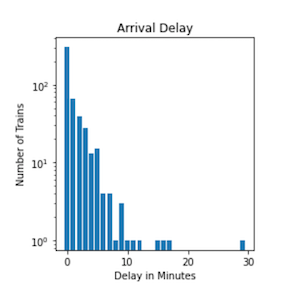

So we require an additional two parameters for every connection. We generally refer to them in code with `delay_probability` and `delay_parameter` for $p$ and $\lambda$ respectively.

### 3.1 Delay analysis

Our objective is then to obtain the delay probability and the mean delay for every possible connection in our "ideal" schedule. However, it is not possible to get exact data for all connections, given that there are often none or only few measurements. To overcome this problem, we have come up with a three-level probability strategy which allows us to select different delays probabilities for the same connections depending on the number of data points supporting it. The levels are as follows:

1. line, station, minute of day
2. line, hour of day
3. transport type, hour of day

If we find that there are not enough data points to reliably estimate the probabilities we move to the next level (from 1. to 2. to 3.). For more details, please refer to [delay_analysis](./delay_analysis.ipynb). 

<a id='predictive-model'></a>
### 3.2 Predictive model

Once we have used the SBB historical data to obtain as much information about the probability of delay for as many connections as possible, it is time to feed our public transport network with this delay data. We "simply" have to merge the "static" transport network with the delay probabilities into a single dataframe shown below. Please refer to [delay_prediction](./delay_prediction.ipynb) for implementation details. Below we present a snippet of the final connections dataframe with the corresponding delay data.

In [14]:
connections = read_csv('/user/datavirus/connections.csv',parts=1)
connections.head()

,stop_sequence,route_type,start_id,start_time,trip_id,transport_type,line_text,stop_time,stop_id,delay_probability,delay_parameter
0,29,900,8591305,13:00:00,1155.TA.26-7-B-j19-1.6.R,tram,7,13:01:00,8591271,0.830450,0.014242
1,28,900,8530812,13:00:00,890.TA.26-11-A-j19-1.3.H,tram,11,13:01:00,8591180,0.851468,0.011924
2,27,900,8591245,12:59:00,1939.TA.26-13-j19-1.24.H,tram,13,13:01:00,8591405,0.847539,0.012390
3,27,900,8591427,12:59:00,3191.TA.26-9-B-j19-1.25.H,tram,9,13:01:00,8573710,0.848292,0.014791
4,27,700,8591197,13:00:00,268.TA.26-308-j19-1.12.R,bus,308,13:01:00,8591434,0.889047,0.012551


<a id = 'algorithm'></a>
## 4. Journey Finder Algorithm

The algorithm we use is based on [Connection Scan Algorithm](https://arxiv.org/abs/1703.05997). We implemented a (non optimized) version and adapted it for our needs. The code is in [journey_finder.py](./journey_finder.py) and contains extensive documentation on how the algorithm works. It roughly works as follows:

### 4.1 Pseudo Algorithm

A list of transport connections a dictionary of footpaths are required as inputs. The footpaths are represented as dictionary with `arrival_station`s as keys and lists of `(departure_station, walking_time)` tuples as values. Given a departure station, arrival station, arrival time and minimum arrival probability the algorithm starts the search process. During the search the algorithm maintains a `stations` datastructure that tracks for each station the outgoing connections from that station that can reach the (directly or indirectly) the arrival station before the specified arrival time and minimum arrival probability. A minimal pseudo code for the algorithm is given below:

```
1. create empty `stations` datastructure
2. scan transport connections in decreasing order of arrival time
3. for each connection do the following
    check if there is already a path to the arrival station from 
    the stop station of the connection
    
    if yes then:
        check whether the current connection can "catch" any connection 
        leaving from it's stop station using `stations`
        
        if yes then:
            calculate the probability of arriving at the arrival station on time
            
            propose the (probability, departure time) of the current connection
            as a new entry to the `stations` entry for the connection's start station
            
            if the new entry is not stricly worse than the last added entry:
                add the entry and the corresponding connection to `stations`
                for the connections's start station
                
                also keep a reference to the follow up connection that has to
                be taken at the current connection's stop station
                
                scan all incoming footpaths to the connections start station:
                    check whether following the footpath and then taking
                    the current connection is a sensible path to take from
                    the footpaths' start station
                    
                    if yes:
                        then add footpath connection to footpaths' start station
                    
```

The algorithm terminates once we scanned through all the connections or a path with 100% arrival probability that cannot be improved is found.


In a second step the best journeys are retrieved from the `stations` datastructure using the. The best journey is defined as the journey that departs as late as possible from the requested departure station and arrives at the arrival station with a probability above the minimum probability. The second best journey is the journey that departs as late as possible but improves the best journey's arrival probability. The third, fourth, ... best journeys are defined in a similar manner.

### 4.2 Calculating Probabilities

Next we explain the calculation of the journey probabilities. Assume we are exploring a connection *c* that goes from *A* to *B* and we are looking for a journey from *S* to *T*. Then we simply look at all connections stored in *B* that arrive with a high enough probability at *T*. For each such connection *d* we calculate the probability to catch *d* if we take *c*. This probability depends on the types of connections: if *c* and *d* belong to the same trip then we cannot miss *d*. Otherwise we have to first calculate how much time we can spend to transfer from *c* to *d*. This is equal to: `departure time of d - arrival time of c - walking time` where walking time is fixed to 120 seconds. The departure and arrival times are according to the planned schedule. To account for delays we now calculate the probability whether *c* is less delayed than the time we have to transfer from *c* to *d*. From this we can, finally, calculate the total probability to reach *T* from *A* via *c* and *d*. This is equal to: `probability to catch d from c * probability to reach T from B by d`. We don't have to calculate the second part of the product because this was already done when *d* was added to B. From all the *d* in *B* we chose the one that maximizes the total probability. This is then the probability to reach *T* from *A* choosing *c*.

<a id = 'interface'></a>

## 5. User Interface

[click here to open the interface](./interface.ipynb)

The user interface is built using [holoviz](http://holoviz.org/) libraries. It consists of two parts: The journey planner and the journey visualizer. The code can be found at [journey_planner.py](./journey_planner.py) and [journey_visualizer](./journey_visualizer).

### 5.1 Journey Planner

The journey planner is where the user chooses the departure and arrival station as well as the arrival time an minimum arrival probability. An image of the interface is show below:

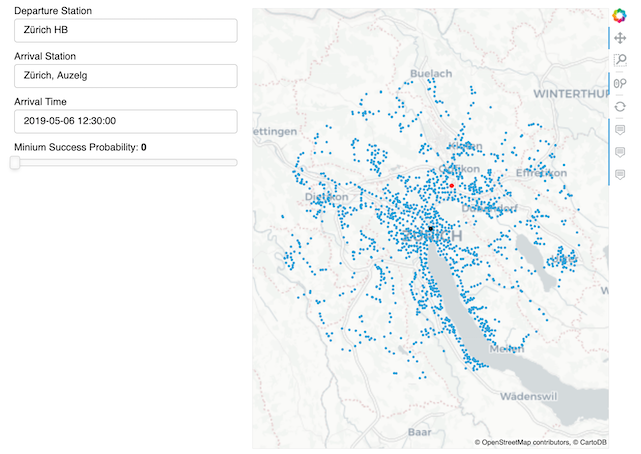

On the left the user can specify the paramters using autocomplete fields for the stations, a text field for the arrival time and a slider for the minimum arrival probability. All possible stations are visualized on the right, departure and arrival stations are highlighted. The user can also select the departure and arrival stations by clicking on the map.

### 5.3 Journey Visualizer

The best journeys found by the journey finder can be visualized using the journey visualizer. Below is an image of the results for the query shown in 5.2. Hovering with the mouse pointer over the different connections reveals extra details about the journey. Clicking on a journey shows the corresponding path on a map on the right.

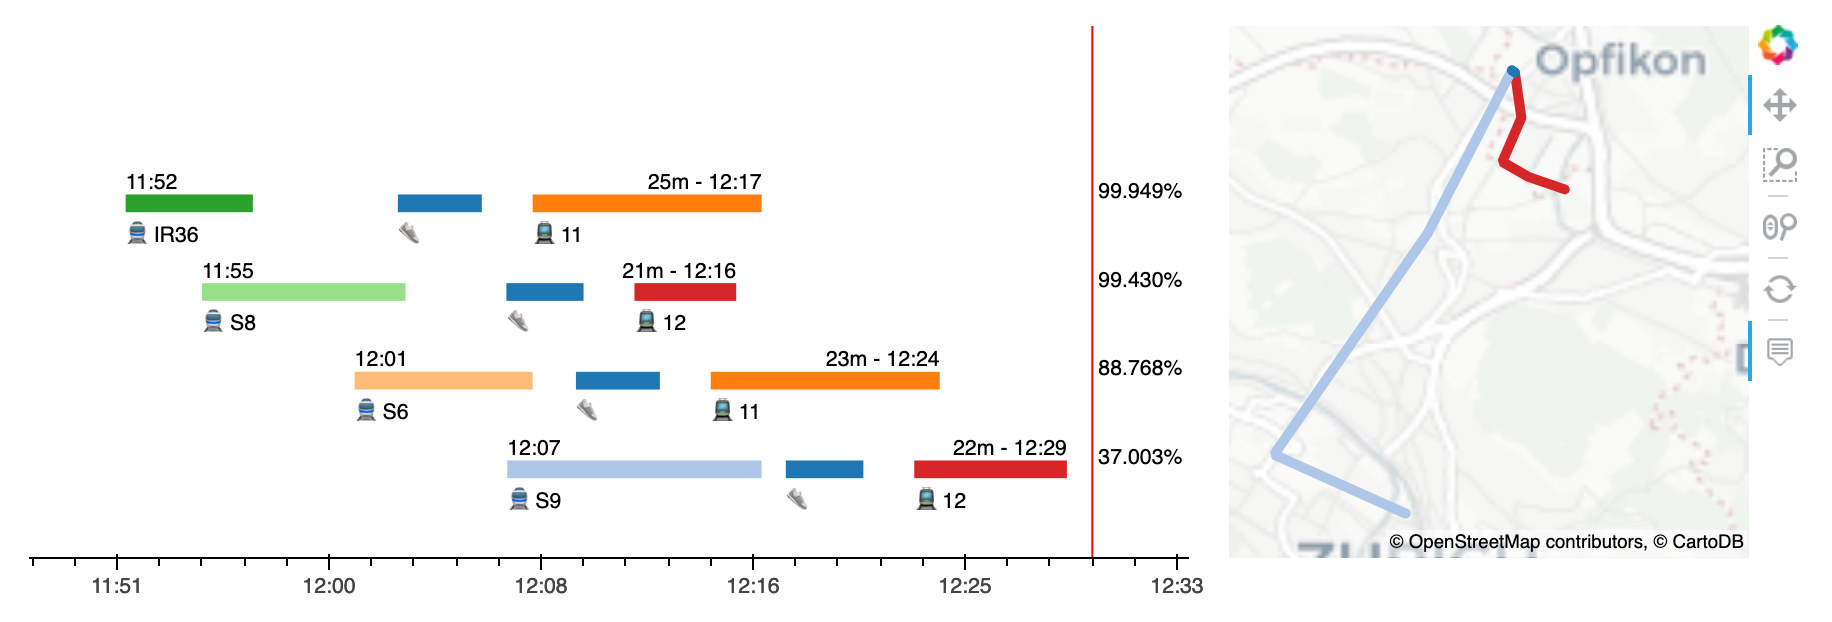

## 6. Validation method

<a id = 'validation'></a>

To demonstrate the validity of our route planner, we compare the output of the planner with the first two routes generated from the connection serch on SBB website. We pick several pairs of station at different time of arrival for the comparison.

#### 6.1 Zürich, Bahnhofquai/HB --> Zürich, ETH Hönggerberg, arrive at 08:30

**SBB**  
Route 1  
Zürich, Bahnhofquai/HB 08:06 --T6--> Zürich, Haldenegg 08:10  
Zürich, Bahnhofquai/HB 08:07 --BE7021-> Zürich, ETH Hönggerberg 08:28  

Route 2  
Zürich, Bahnhofquai/HB 08:04 --B46--> Zürich, Meierhofplatz 08:17  
Zürich, Meierhofplatz 08:22 --B80-> Zürich, ETH Hönggerberg 08:25  

**Our planner**

In [ ]:
interface.journeys()

**Comparison**  
- Compared with route 1 generated from SBB, our first result without thershold for the success probability departs earlier and arrive later. SBB may exclude this result due to its low success probability. Looking at our fourth result, after 9 min working, the route takes the same bus as the SBB's one. The difference between the route and SBB's first out could be from the difference of the acceptance walking time.
- As for route 2 generated from SBB, we have exact same route in our planning.


#### 6.2 Zürich HB --> Zürich, Auzelg, arrive at 12:30

**SBB**  
Route 1  
Zürich, HB 12:07 --S9--> Glattbrugg, Platform3 12:17  
Glattbrugg, Platform3 12:17 --Feet--> Glattbrugg, Bahnhof 12:20  
Glattbrugg, Bahnhof 12:23 --T12-> Zürich, Auzelg 12:29  

Route 2  
Zürich, HB 12:05 --RE4920--> Zürich Oerlikon 12:11  
Zürich Oerlikon 12:11 --Feet--> Zürich Oerlikon, Bahnhof 12:15  
Zürich Oerlikon, Bahnhof 12:15 --T11-> Zürich, Auzelg 12:24  


**Our planner**

In [ ]:
interface.journeys()

#### Comparison  
- For the routes that arrive at latest time, our planner and SBB (Route1) generate exact same route.
- For route2 generated from SBB, we cannot find it in our output. The route departs earlier than our first route and indicates lower probability of success of arrival on time due to the tight transfer schedule. Thus, it was excluded from our result.


#### 6.3 Zürich, Haldenegg --> Oberengstringen, Lanzrain, arrive at 19:00

**SBB**  
Route 1  
Zürich, Haldenegg 18:16 --T10--> Zürich, Bahnhofplatz/HB 18:20  
Zürich, Bahnhofplatz/HB 18:20 --Foot--> Zürich HB 18:27  
Zürich, HB 18:29 --S11-> Schliere 18:38  
Schliere 18:38 --Foot--> Schliere 18:41  
Schliere 18:41 --B308--> Oberengstringen, Lanzrain 18:55  

Route 2  
Zürich, Haldenegg 18:08 --T6--> Zürich, Tüffenwies 18:28  
Zürich, Tüffenwies 18:36 --B304--> Oberengstringen, Lanzrain 18:43

**Our planner**

In [ ]:
interface.journeys()

#### Comparison
- Since our planner accept longer walking time than SBB, we got our second route and it covers the first route generated from SBB.
- Compared with route 2 generated from SBB, our third route departs later and arrives at the same time; our route superior to the one from SBB.

#### 6.4 Conclusion
- Due to the difference of the assumption such as acceptable walking time, our results sometime differ from the one from SBB.
- However, the difference in the planned route is readonable and our suggested routes are occasionally better.
- From the experiment above, we conclude that our algorithm is a valid route planner.